In [1]:
import os
import tensorflow as tf

from typing import Callable
from tensorflow import keras
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from functions.plotting import plot_single_output_history
WIDTH = 150
HEIGHT = 150

In [2]:
base_data1_dir = os.path.join('..', '..', 'data1', 'images_original_inception_resnet_v2_150x150_categorized_no_nv')
train_data1_dir = os.path.join(base_data1_dir, 'training')
valid_data1_dir = os.path.join(base_data1_dir, 'validation')

train1_ds = keras.utils.image_dataset_from_directory(
    directory=train_data1_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(HEIGHT, WIDTH))
valid1_ds = keras.utils.image_dataset_from_directory(
    directory=valid_data1_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(HEIGHT, WIDTH))

Found 2651 files belonging to 9 classes.
Found 659 files belonging to 9 classes.


In [3]:
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip('horizontal_and_vertical'),
    keras.layers.RandomRotation(1),
    keras.layers.RandomBrightness((-.3, .3)),
    keras.layers.RandomContrast(.3),
    keras.layers.RandomZoom((.3, -.3), (.3, -.3))
])
train1_ds = train1_ds\
    .cache()\
    .shuffle(1000)\
    .map(lambda x, y: (data_augmentation(x), y))\
    .prefetch(buffer_size=tf.data.AUTOTUNE)
valid1_ds = valid1_ds\
    .cache()\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

In [4]:
num_classes = 9

In [5]:
def run_model(
        model_factory: Callable,
        model_name: str,
        reduction_patience=5):
    MIN_DELTA = .001
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=10,
        min_delta=MIN_DELTA)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        mode='max',
        factor=0.95,
        min_delta=MIN_DELTA,
        patience=reduction_patience,
        min_lr=0.0005,
        verbose=1)
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join('..', 'models', model_name + '_{epoch}'),
        monitor='val_accuracy',
        save_best_only=True)
    tensor_board = keras.callbacks.TensorBoard(log_dir=os.path.join('..', 'tensor_logs', model_name))
    model = model_factory()

    return model.fit(
        train1_ds,
        validation_data=valid1_ds,
        epochs=100,
        batch_size=64,
        callbacks=[reduce_lr, model_checkpoint, tensor_board, early_stopping])

In [11]:
def get_basic_model() -> keras.Model:
    base_model = InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(HEIGHT, WIDTH, 3))
    flat = keras.layers.Flatten()(base_model.output)
    locator_module = keras.layers.Dense(2048, activation='relu')(flat)
    locator_module = keras.layers.Dropout(.3)(locator_module)
    locator_module = keras.layers.Dense(num_classes, activation='softmax')(locator_module)
    model = keras.Model(base_model.input, outputs=locator_module)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
history0 = run_model(get_basic_model, 'inception_resnet_data1_v2_0')

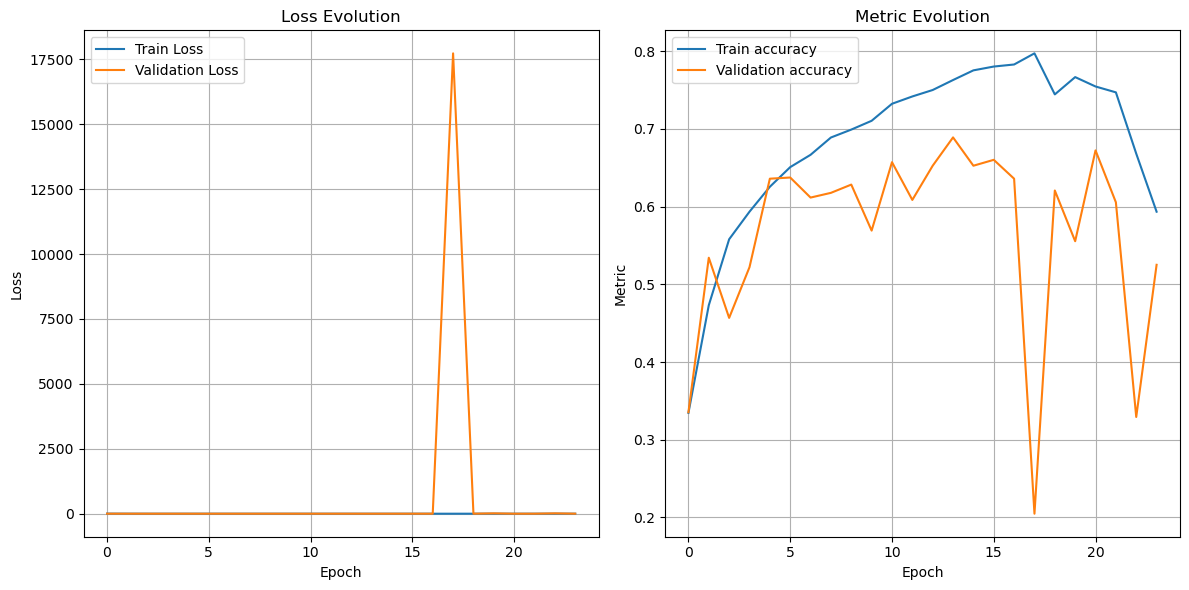

In [13]:
plot_single_output_history(history0)

In [14]:
def get_model_partly_frozen() -> keras.Model:
    base_model = InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(HEIGHT, WIDTH, 3))

    for cnt in range(len(base_model.layers) // 2, len(base_model.layers)):
        base_model.layers[cnt].trainable = False

    flat = keras.layers.Flatten()(base_model.output)
    locator_module = keras.layers.Dense(4608, activation='relu')(flat)
    locator_module = keras.layers.Dropout(.3)(locator_module)
    locator_module = keras.layers.Dense(2048, activation='relu')(locator_module)
    locator_module = keras.layers.Dropout(.3)(locator_module)
    locator_module = keras.layers.Dense(num_classes, activation='softmax')(locator_module)
    model = keras.Model(base_model.input, outputs=locator_module)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
history1 = run_model(get_model_partly_frozen, 'inception_resnet_data1_v2_1')

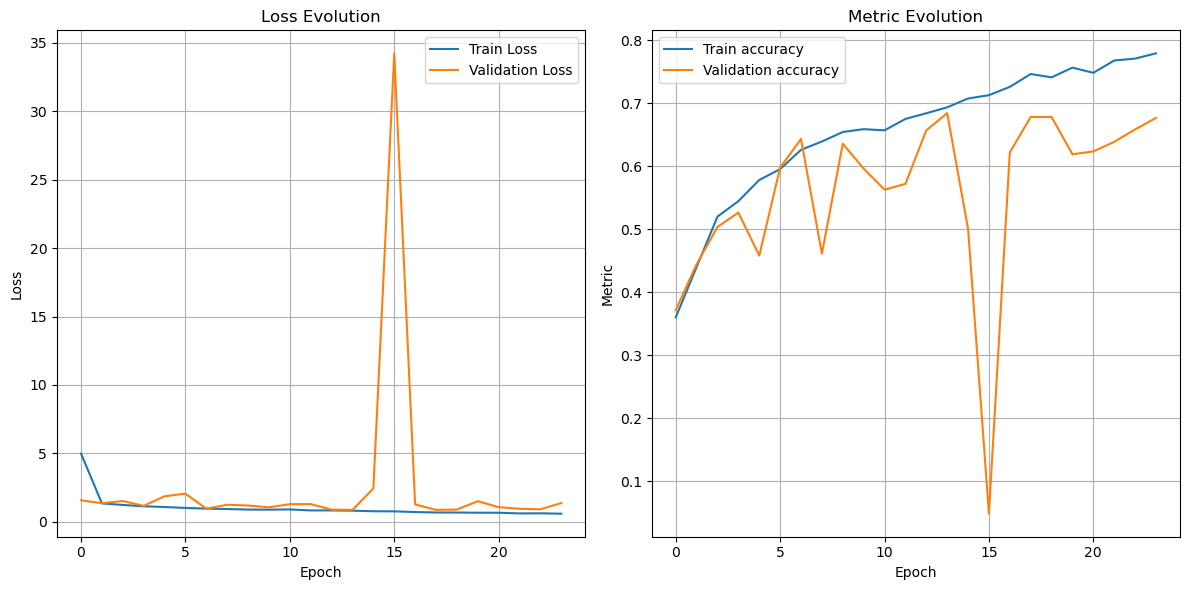

In [16]:
plot_single_output_history(history1)

In [6]:
def get_model_with_attention() -> keras.Model:
    def get_attention_module(prev: keras.layers.Layer) -> keras.layers.Layer:
        gap_layer = keras.layers.GlobalAveragePooling2D()(prev)
        gap_layer_res = keras.layers.Reshape((1, 1, 1536))(gap_layer)
        dense = keras.layers.Dense(1536, activation='relu')(gap_layer_res)
        dense = keras.layers.Dense(1536, activation='softmax')(dense)
        mul_layer = keras.layers.Multiply()([prev, dense])

        return mul_layer

    base_model = InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(HEIGHT, WIDTH, 3))
    attention_module = get_attention_module(base_model.output)
    flat = keras.layers.Flatten()(attention_module)
    locator_module = keras.layers.Dense(4608, activation='relu')(flat)
    locator_module = keras.layers.Dropout(.3)(locator_module)
    locator_module = keras.layers.Dense(2048, activation='relu')(locator_module)
    locator_module = keras.layers.Dropout(.3)(locator_module)
    locator_module = keras.layers.Dense(num_classes, activation='softmax')(locator_module)
    model = keras.Model(base_model.input, outputs=locator_module)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
history2 = run_model(get_model_with_attention, 'inception_resnet_data1_v2_2')

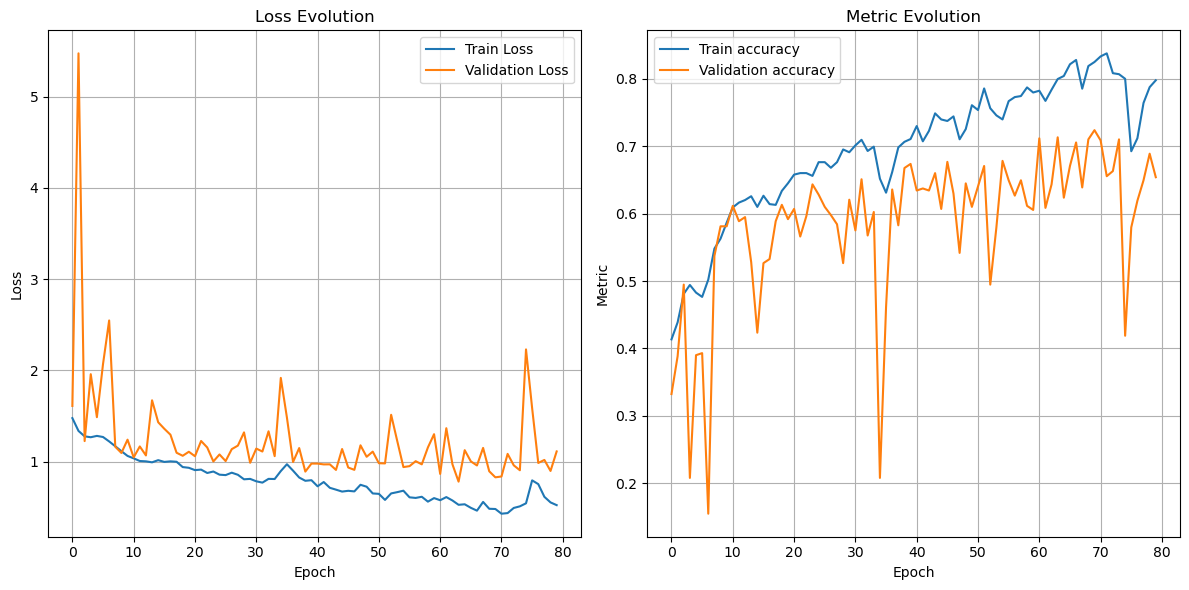

In [8]:
plot_single_output_history(history2)